In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
print("Bibliotheken erfolgreich geladen!")



Bibliotheken erfolgreich geladen!


In [4]:
df = pd.read_csv('../data/raw/OnlineRetail.csv', encoding='ISO-8859-1')
print(f"Datensatz geladen!")
print(f"Anzahl Zeilen: {len(df):,}")
print(f"Anzahl Spalten: {df.shape[1]}")
print(f"\nErste 5 Zeilen: ")
df.head()

Datensatz geladen!
Anzahl Zeilen: 541,909
Anzahl Spalten: 8

Erste 5 Zeilen: 


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
print("Spalten im Datensatz:")
print(df.info())
print("\n" + "=" * 50)
print("\nStatistische Übersicht:")
df.describe()

Spalten im Datensatz:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


Statistische Übersicht:


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [15]:
# Zeilen ohne CustomerID entfernen
print(f"Vor Bereinigung: {len(df):,} Zeilen")
df_clean = df[df['CustomerID'].notna()].copy()
print(f"Nach Entfernen fehlender CustomerIDs: {len(df_clean):,} Zeilen")

# Nur positive Mengen (Keine Retouren)
df_clean = df_clean[df_clean['Quantity'] > 0]
df_clean = df_clean[df_clean['UnitPrice'] > 0]
print(f"Nach Entfernen negativer Werte: {len(df_clean):,} Zeilen")

# Gesamtepreis berechnen
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# InvoiceDate in Datetime umwandeln
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

print(f"\n Daten bereinigt!")
print(f"Anzahl einzigartiger Kunden: {df_clean['CustomerID'].nunique():,}")
df_clean.head()





Vor Bereinigung: 541,909 Zeilen
Nach Entfernen fehlender CustomerIDs: 406,829 Zeilen
Nach Entfernen negativer Werte: 397,884 Zeilen

 Daten bereinigt!
Anzahl einzigartiger Kunden: 4,338


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [20]:
# Referenzdatum (1 Tag nach letzter Transaktion im Datensatz)
reference_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Referenzdatum: {reference_date}")

customer_features = df_clean.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',                 # Anzahl Bestellungen(Frequency)
    'TotalPrice': 'sum',                    # Gesamtumsatz(Monetary)
    'Quantity': 'sum',                      # Anzahl gekaufter Produkte
    'InvoiceDate': 'max'                    # Datum der letzten Bestellung
}).reset_index()

# Spalten umbenennen
customer_features.columns = ['CustomerID', 'Anzahl_Bestellungen', 'Gesamtumsatz', 'Anzahl_Produkte', 'Letzte_Bestellung']

# Recency berechnen
customer_features['Recency_Tage'] = (reference_date - customer_features['Letzte_Bestellung']).dt.days

# Durchschnittlicher Warenkorb
customer_features['Avg_Warenkorbwert'] = (customer_features['Gesamtumsatz'] /
                                           customer_features['Anzahl_Bestellungen'])
# Durchschnittliche Produkte pro Bestellung
customer_features['Avg_Produkte_pro_Bestellung'] = (customer_features['Anzahl_Produkte'] / 
                                                     customer_features['Anzahl_Bestellungen'])
print(f"\nFeatures erstellt für {len(customer_features):,} Kunden!")
print("\nErste 10 Kunden:")
customer_features.head(10)

Referenzdatum: 2011-12-10 12:50:00

Features erstellt für 4,338 Kunden!

Erste 10 Kunden:


,CustomerID,Anzahl_Bestellungen,Gesamtumsatz,Anzahl_Produkte,Letzte_Bestellung,Recency_Tage,Avg_Warenkorbwert,Avg_Produkte_pro_Bestellung
0,12346.0,1,77183.60,74215,2011-01-18 10:01:00,326,77183.600000,74215.000000
1,12347.0,7,4310.00,2458,2011-12-07 15:52:00,2,615.714286,351.142857
2,12348.0,4,1797.24,2341,2011-09-25 13:13:00,75,449.310000,585.250000
3,12349.0,1,1757.55,631,2011-11-21 09:51:00,19,1757.550000,631.000000
4,12350.0,1,334.40,197,2011-02-02 16:01:00,310,334.400000,197.000000
5,12352.0,8,2506.04,536,2011-11-03 14:37:00,36,313.255000,67.000000
6,12353.0,1,89.00,20,2011-05-19 17:47:00,204,89.000000,20.000000
7,12354.0,1,1079.40,530,2011-04-21 13:11:00,232,1079.400000,530.000000
8,12355.0,1,459.40,240,2011-05-09 13:49:00,214,459.400000,240.000000
9,12356.0,3,2811.43,1591,2011-11-17 08:40:00,23,937.143333,530.333333


In [22]:
print("Statistische Übersicht der Features:")
print("=" * 50)
customer_features[['Anzahl_Bestellungen', 'Gesamtumsatz', 'Anzahl_Produkte', 'Recency_Tage', 'Avg_Warenkorbwert']].describe()

Statistische Übersicht der Features:


,Anzahl_Bestellungen,Gesamtumsatz,Anzahl_Produkte,Recency_Tage,Avg_Warenkorbwert
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,4.272015,2054.266460,1191.289073,92.536422,419.166289
std,7.697998,8989.230441,5046.081546,100.014169,1796.537944
min,1.000000,3.750000,1.000000,1.000000,3.450000
25%,1.000000,307.415000,160.000000,18.000000,178.625000
50%,2.000000,674.485000,379.000000,51.000000,293.900000
75%,5.000000,1661.740000,992.750000,142.000000,430.113750
max,209.000000,280206.020000,196915.000000,374.000000,84236.250000


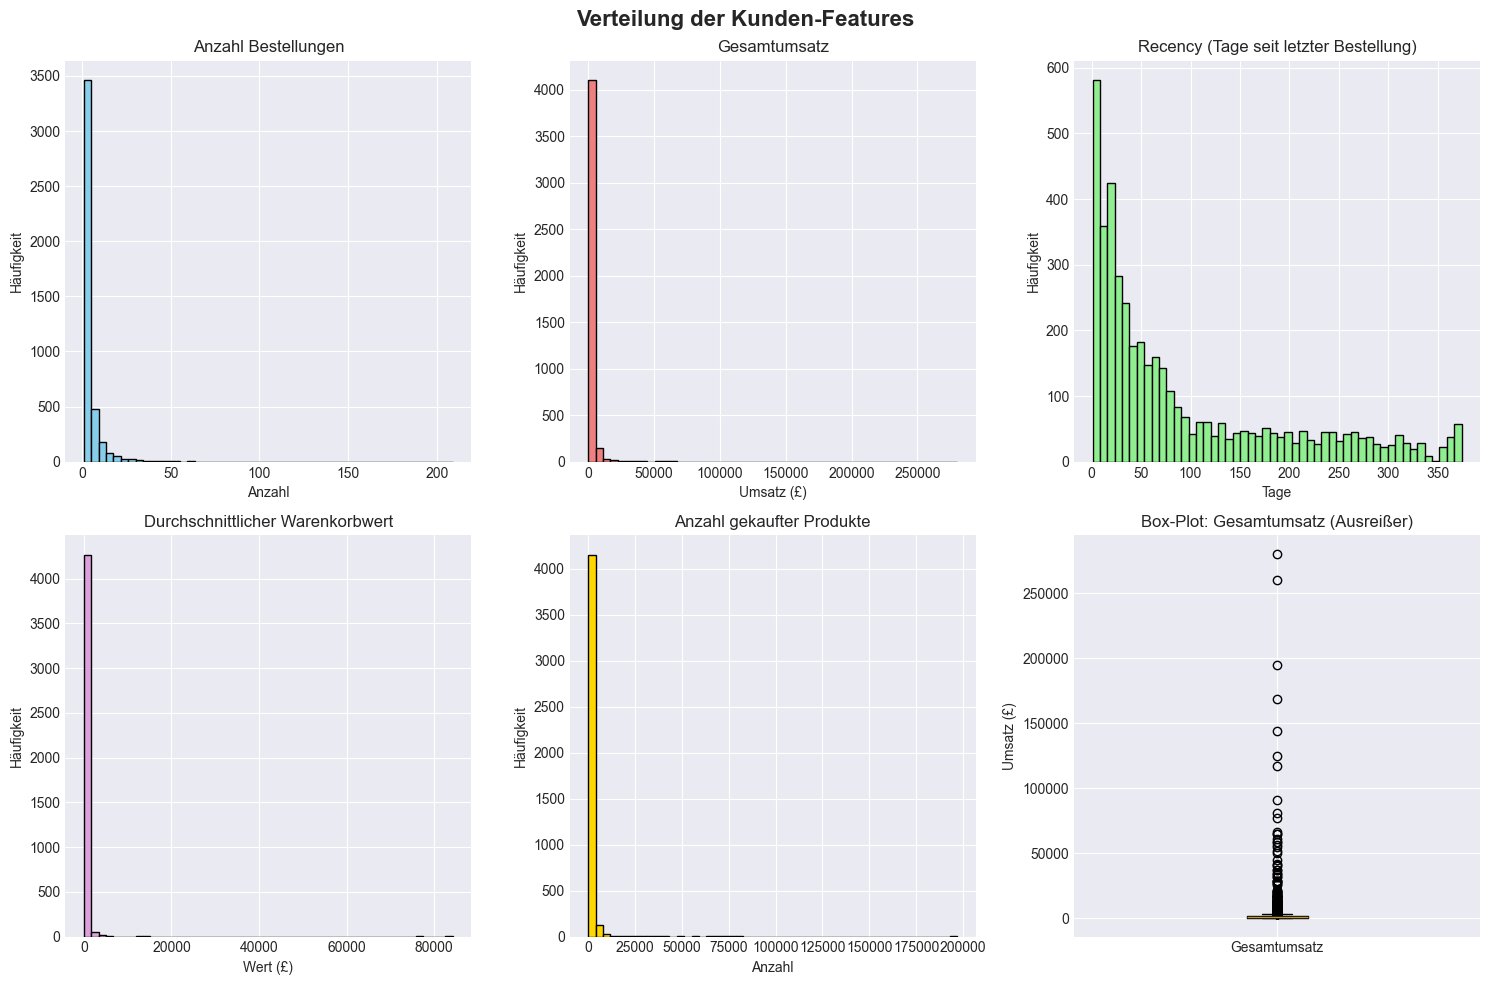


 Was wir sehen:
- Die meisten Features sind stark rechtsschief (viele kleine Werte, wenige große)
- Es gibt Ausreißer (sehr hohe Umsätze)
- Für Clustering sollten wir die Daten skalieren!


In [25]:
# Visualisierung der Feature-Verteilungen
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Verteilung der Kunden-Features', fontsize=16, fontweight='bold')

# Anzahl Bestellungen
axes[0, 0].hist(customer_features['Anzahl_Bestellungen'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Anzahl Bestellungen')
axes[0, 0].set_xlabel('Anzahl')
axes[0, 0].set_ylabel('Häufigkeit')

#  Gesamtumsatz
axes[0, 1].hist(customer_features['Gesamtumsatz'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Gesamtumsatz')
axes[0, 1].set_xlabel('Umsatz (£)')
axes[0, 1].set_ylabel('Häufigkeit')

#  Recency
axes[0, 2].hist(customer_features['Recency_Tage'], bins=50, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Recency (Tage seit letzter Bestellung)')
axes[0, 2].set_xlabel('Tage')
axes[0, 2].set_ylabel('Häufigkeit')

#  Durchschnittlicher Warenkorbwert
axes[1, 0].hist(customer_features['Avg_Warenkorbwert'], bins=50, color='plum', edgecolor='black')
axes[1, 0].set_title('Durchschnittlicher Warenkorbwert')
axes[1, 0].set_xlabel('Wert (£)')
axes[1, 0].set_ylabel('Häufigkeit')

#  Anzahl Produkte
axes[1, 1].hist(customer_features['Anzahl_Produkte'], bins=50, color='gold', edgecolor='black')
axes[1, 1].set_title('Anzahl gekaufter Produkte')
axes[1, 1].set_xlabel('Anzahl')
axes[1, 1].set_ylabel('Häufigkeit')

#  Box-Plot für Ausreißer
axes[1, 2].boxplot([customer_features['Gesamtumsatz']], labels=['Gesamtumsatz'])
axes[1, 2].set_title('Box-Plot: Gesamtumsatz (Ausreißer)')
axes[1, 2].set_ylabel('Umsatz (£)')

plt.tight_layout()
plt.savefig('../results/figures/Verteilungs_Plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Was wir sehen:")
print("- Die meisten Features sind stark rechtsschief (viele kleine Werte, wenige große)")
print("- Es gibt Ausreißer (sehr hohe Umsätze)")
print("- Für Clustering sollten wir die Daten skalieren!")

Features für Clustering ausgewählt:
   Gesamtumsatz  Anzahl_Bestellungen
0      77183.60                    1
1       4310.00                    7
2       1797.24                    4
3       1757.55                    1
4        334.40                    1
5       2506.04                    8
6         89.00                    1
7       1079.40                    1
8        459.40                    1
9       2811.43                    3


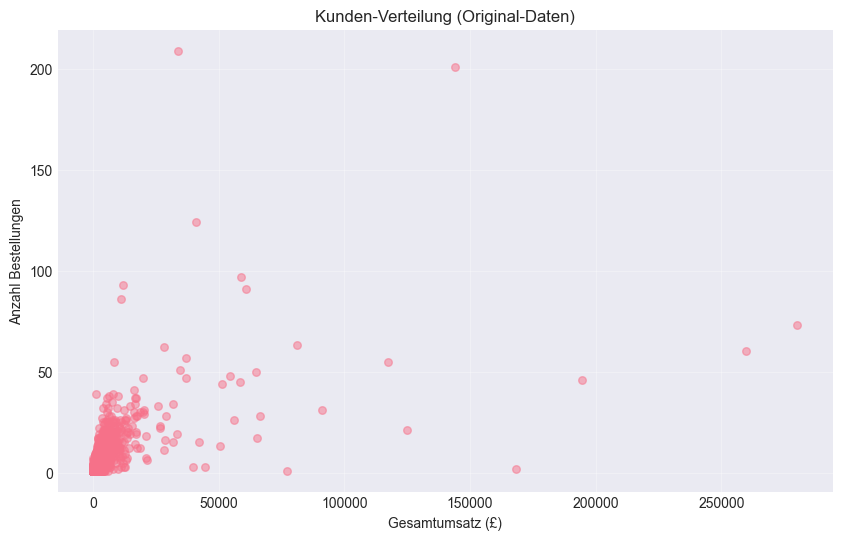


Problem: Wenige Punkte mit extrem hohen Werten dominieren die Skala!


In [29]:
# Für Clustering wählen wir die wichtigsten Features

# Gesamtumsatz + Anzahl Bestellungen
clustering_features = customer_features[['Gesamtumsatz', 'Anzahl_Bestellungen']].copy()

print("Features für Clustering ausgewählt:")
print(clustering_features.head(10))

# Scatter Plot VOR Transformation
plt.figure(figsize=(10, 6))
plt.scatter(clustering_features['Gesamtumsatz'], 
            clustering_features['Anzahl_Bestellungen'],
            alpha=0.5, s=30)
plt.xlabel('Gesamtumsatz (£)')
plt.ylabel('Anzahl Bestellungen')
plt.title('Kunden-Verteilung (Original-Daten)')
plt.grid(True, alpha=0.3)
plt.show()

print("\nProblem: Wenige Punkte mit extrem hohen Werten dominieren die Skala!")

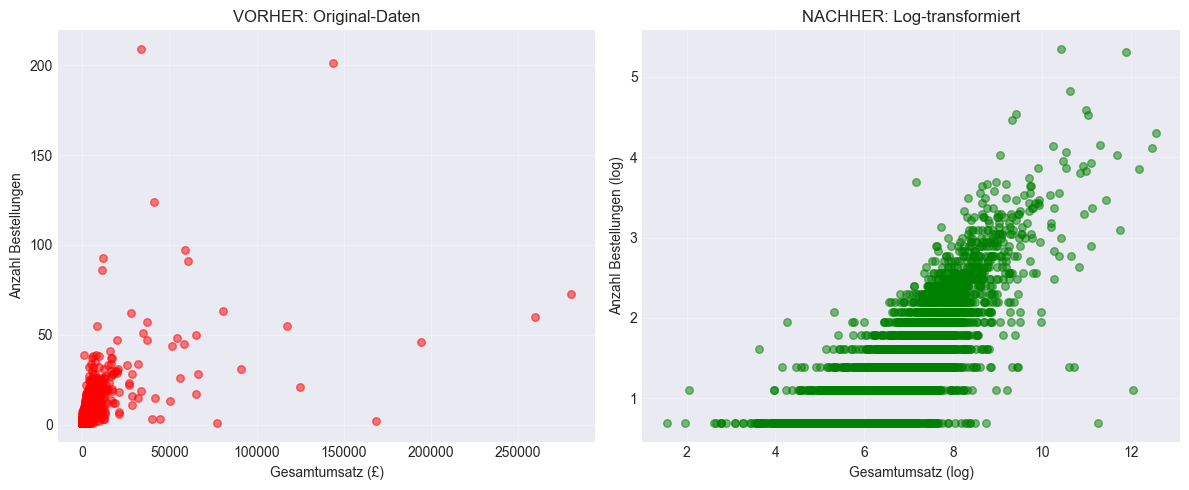

 Log-Transformation angewendet!
Die Daten sind jetzt besser verteilt und Ausreißer haben weniger Einfluss.


In [30]:
from sklearn.preprocessing import StandardScaler

# Log-Transformation (log1p = log(x+1), um 0-Werte zu handhaben)
clustering_features_log = clustering_features.copy()
clustering_features_log['Gesamtumsatz_log'] = np.log1p(clustering_features['Gesamtumsatz'])
clustering_features_log['Anzahl_Bestellungen_log'] = np.log1p(clustering_features['Anzahl_Bestellungen'])

# Nach Log-Transformation anschauen
plt.figure(figsize=(12, 5))

# Vorher
plt.subplot(1, 2, 1)
plt.scatter(clustering_features['Gesamtumsatz'], 
            clustering_features['Anzahl_Bestellungen'],
            alpha=0.5, s=30, color='red')
plt.xlabel('Gesamtumsatz (£)')
plt.ylabel('Anzahl Bestellungen')
plt.title('VORHER: Original-Daten')
plt.grid(True, alpha=0.3)

# Nachher (log)
plt.subplot(1, 2, 2)
plt.scatter(clustering_features_log['Gesamtumsatz_log'], 
            clustering_features_log['Anzahl_Bestellungen_log'],
            alpha=0.5, s=30, color='green')
plt.xlabel('Gesamtumsatz (log)')
plt.ylabel('Anzahl Bestellungen (log)')
plt.title('NACHHER: Log-transformiert')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" Log-Transformation angewendet!")
print("Die Daten sind jetzt besser verteilt und Ausreißer haben weniger Einfluss.")

Features nach Standardisierung:
       Gesamtumsatz_scaled  Anzahl_Bestellungen_scaled
count         4.338000e+03                4.338000e+03
mean          2.817274e-16               -8.189750e-18
std           1.000115e+00                1.000115e+00
min          -4.004574e+00               -9.552143e-01
25%          -6.856676e-01               -9.552143e-01
50%          -6.218718e-02               -3.615828e-01
75%           6.541861e-01                6.532370e-01
max           4.731591e+00                5.858535e+00


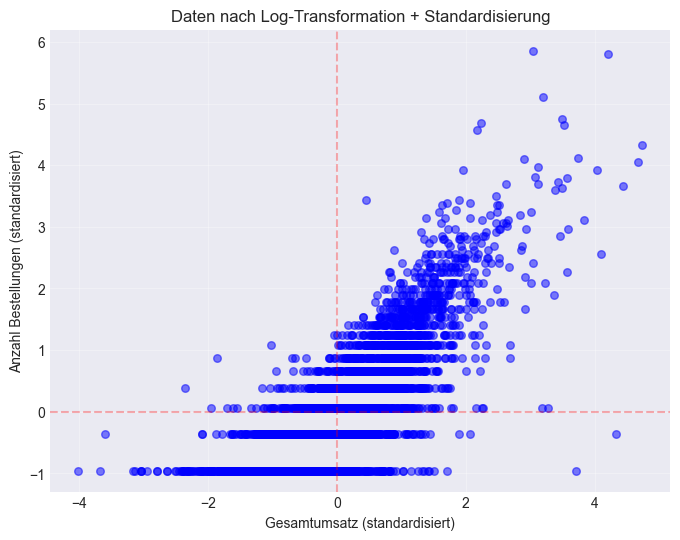


 Daten sind jetzt bereit für Clustering!
Shape: (4338, 2) (4338 Kunden, 2 Features)


In [31]:
# Standardisierung: Mittelwert=0, Standardabweichung=1
scaler = StandardScaler()

# Nur die log-transformierten Spalten nutzen
X = clustering_features_log[['Gesamtumsatz_log', 'Anzahl_Bestellungen_log']].values
X_scaled = scaler.fit_transform(X)

# Als DataFrame speichern
X_scaled_df = pd.DataFrame(X_scaled, 
                           columns=['Gesamtumsatz_scaled', 'Anzahl_Bestellungen_scaled'])

print("Features nach Standardisierung:")
print(X_scaled_df.describe())

# Visualisierung nach Standardisierung
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled_df['Gesamtumsatz_scaled'], 
            X_scaled_df['Anzahl_Bestellungen_scaled'],
            alpha=0.5, s=30, color='blue')
plt.xlabel('Gesamtumsatz (standardisiert)')
plt.ylabel('Anzahl Bestellungen (standardisiert)')
plt.title('Daten nach Log-Transformation + Standardisierung')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.show()

print("\n Daten sind jetzt bereit für Clustering!")
print(f"Shape: {X_scaled.shape} (4338 Kunden, 2 Features)")

In [35]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# HAC mit verschiedenen Linkage-Methoden durchführen
linkage_methods = ['single', 'complete', 'average', 'ward']

# Für jede Methode Linkage berechnen
linkages = {}
for method in linkage_methods:
    linkages[method] = linkage(X_scaled, method=method)
    print(f" -> {method.upper()} Linkage berechnet")

print("\nHAC Hierarchien erstellt!")

 -> SINGLE Linkage berechnet
 -> COMPLETE Linkage berechnet
 -> AVERAGE Linkage berechnet
 -> WARD Linkage berechnet

HAC Hierarchien erstellt!


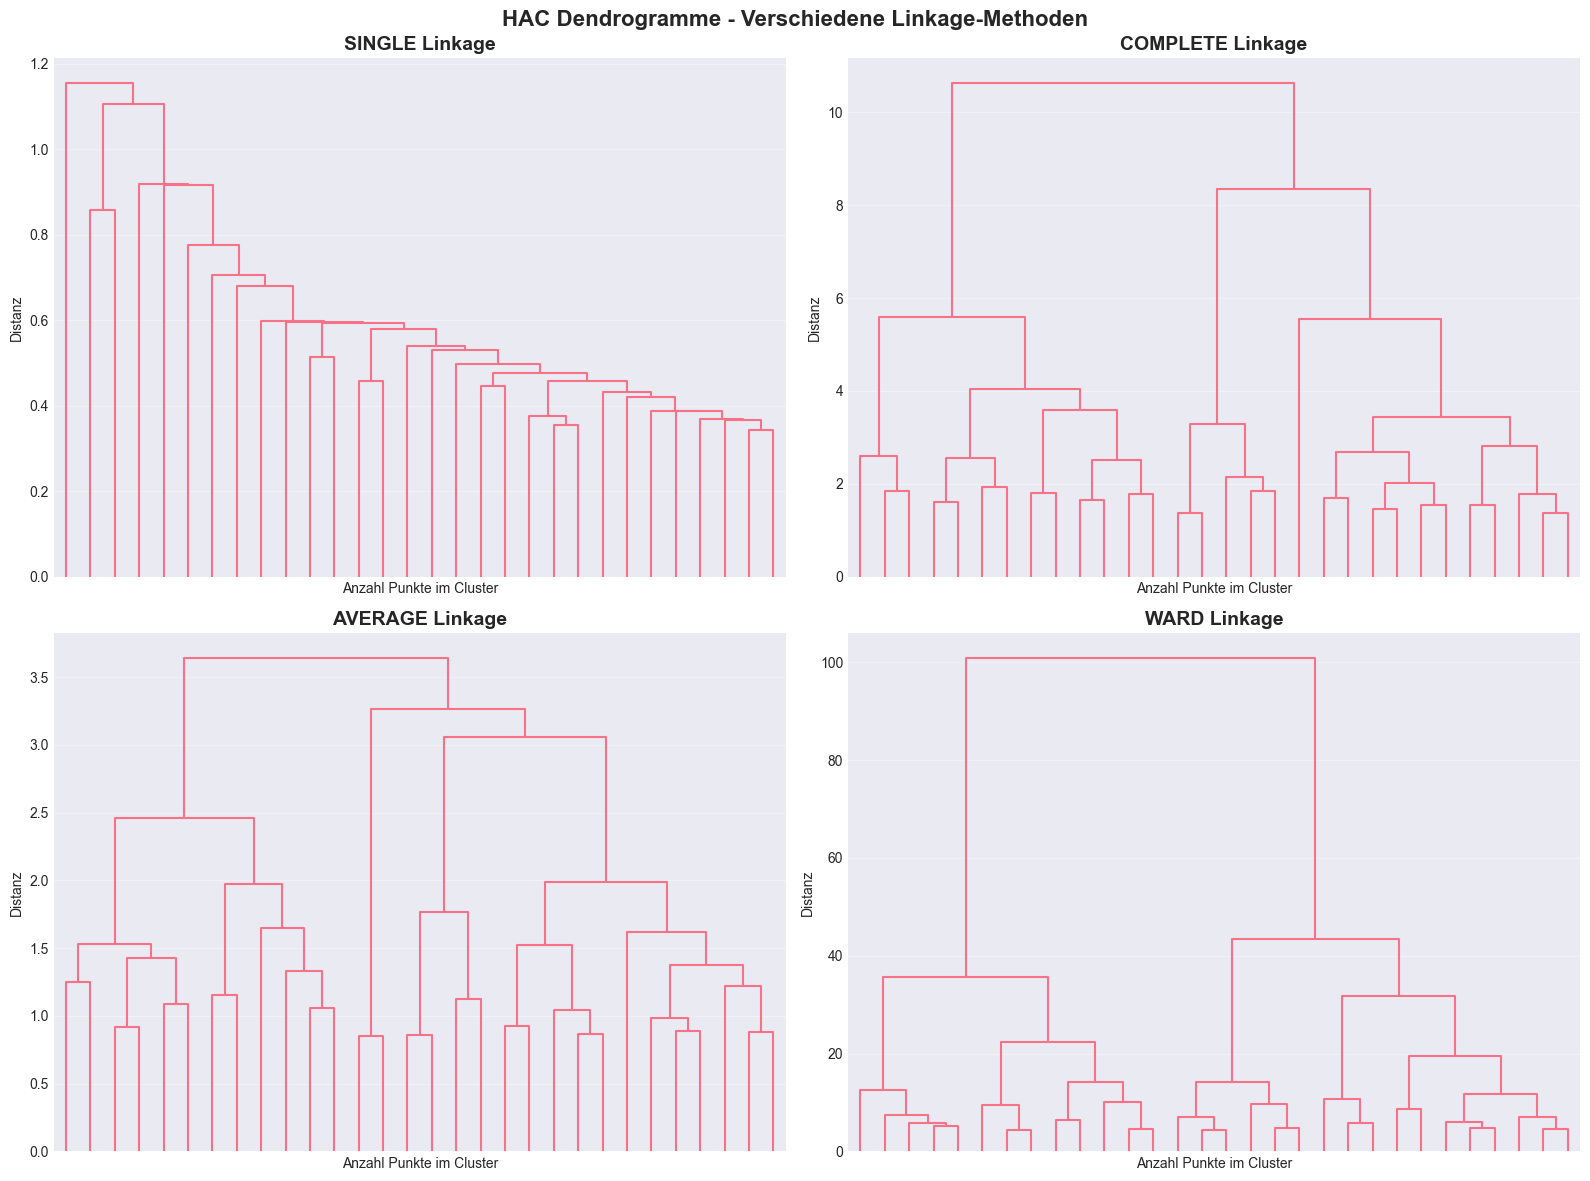


 Beobachtungen:
- SINGLE: Neigt zu 'Chaining' (lange dünne Cluster)
- COMPLETE: Erzeugt kompakte Cluster
- AVERAGE: Guter Kompromiss
- WARD: Minimiert Varianz, erzeugt ausgewogene Cluster (meist beste Wahl)


In [38]:
# Dendrogramme für alle 4 Methoden plotten
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('HAC Dendrogramme - Verschiedene Linkage-Methoden', 
             fontsize=16, fontweight='bold')

# Farben für bessere Darstellung
colors = ['skyblue', 'lightcoral', 'lightgreen', 'plum']

for idx, (method, ax) in enumerate(zip(linkage_methods, axes.flatten())):
    dendrogram(linkages[method], 
               ax=ax,
               truncate_mode='lastp',  # Nur letzte p Cluster zeigen
               p=30,                    # Anzahl zu zeigender Cluster
               no_labels=True,
               color_threshold=0)
    
    ax.set_title(f'{method.upper()} Linkage', fontsize=14, fontweight='bold')
    ax.set_xlabel('Anzahl Punkte im Cluster')
    ax.set_ylabel('Distanz')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/02_Dendrogramme.png', dpi=300, bbox_inches= 'tight')
plt.show()

print("\n Beobachtungen:")
print("- SINGLE: Neigt zu 'Chaining' (lange dünne Cluster)")
print("- COMPLETE: Erzeugt kompakte Cluster")
print("- AVERAGE: Guter Kompromiss")
print("- WARD: Minimiert Varianz, erzeugt ausgewogene Cluster (meist beste Wahl)")

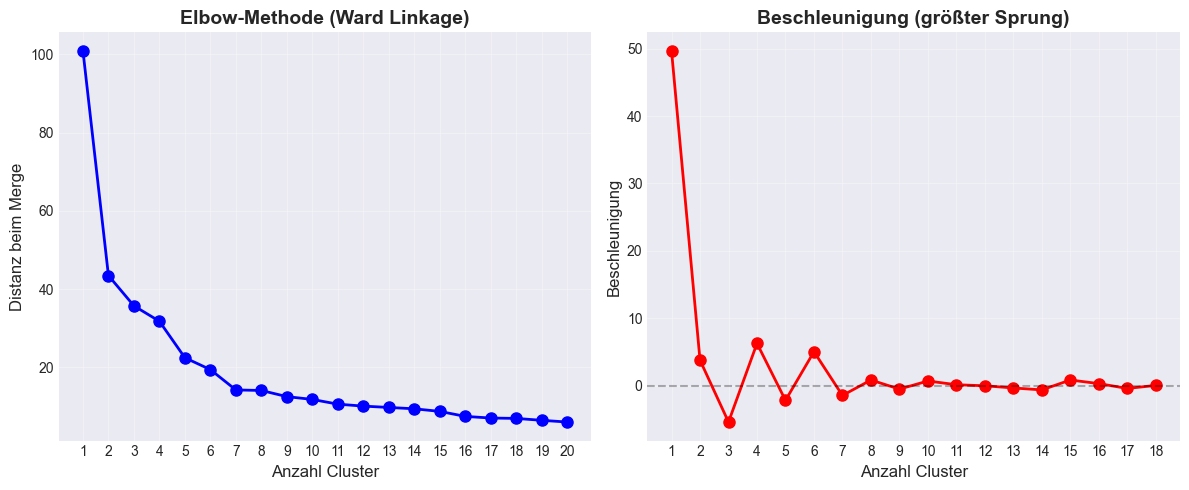


 Empfohlene Cluster-Anzahl: 1
   (Größter Sprung in der Distanz)

Typische Wahl: 3-5 Cluster für interpretierbare Kundensegmente


In [40]:
# Elbow-Methode: Distanzen bei jedem Merge anschauen
ward_linkage = linkages['ward']

# Die letzten Merges haben die größten Distanzen
last_merges = ward_linkage[-20:, 2]  # Letzte 20 Merge-Distanzen
clusters_range = range(20, 0, -1)    # Von 20 bis 1 Cluster

plt.figure(figsize=(12, 5))

# Plot 1: Elbow-Kurve
plt.subplot(1, 2, 1)
plt.plot(clusters_range, last_merges, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Anzahl Cluster', fontsize=12)
plt.ylabel('Distanz beim Merge', fontsize=12)
plt.title('Elbow-Methode (Ward Linkage)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 21))

# Plot 2: Distanz-Unterschiede (Beschleunigung)
plt.subplot(1, 2, 2)
acceleration = np.diff(last_merges, 2)  # Zweite Ableitung
plt.plot(range(18, 0, -1), acceleration, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Anzahl Cluster', fontsize=12)
plt.ylabel('Beschleunigung', fontsize=12)
plt.title('Beschleunigung (größter Sprung)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.xticks(range(1, 19))

plt.tight_layout()
plt.show()

# Optimale Cluster-Anzahl vorschlagen
max_acceleration_idx = np.argmax(acceleration)
optimal_clusters = 18 - max_acceleration_idx

print(f"\n Empfohlene Cluster-Anzahl: {optimal_clusters}")
print(f"   (Größter Sprung in der Distanz)")
print("\nTypische Wahl: 3-5 Cluster für interpretierbare Kundensegmente")

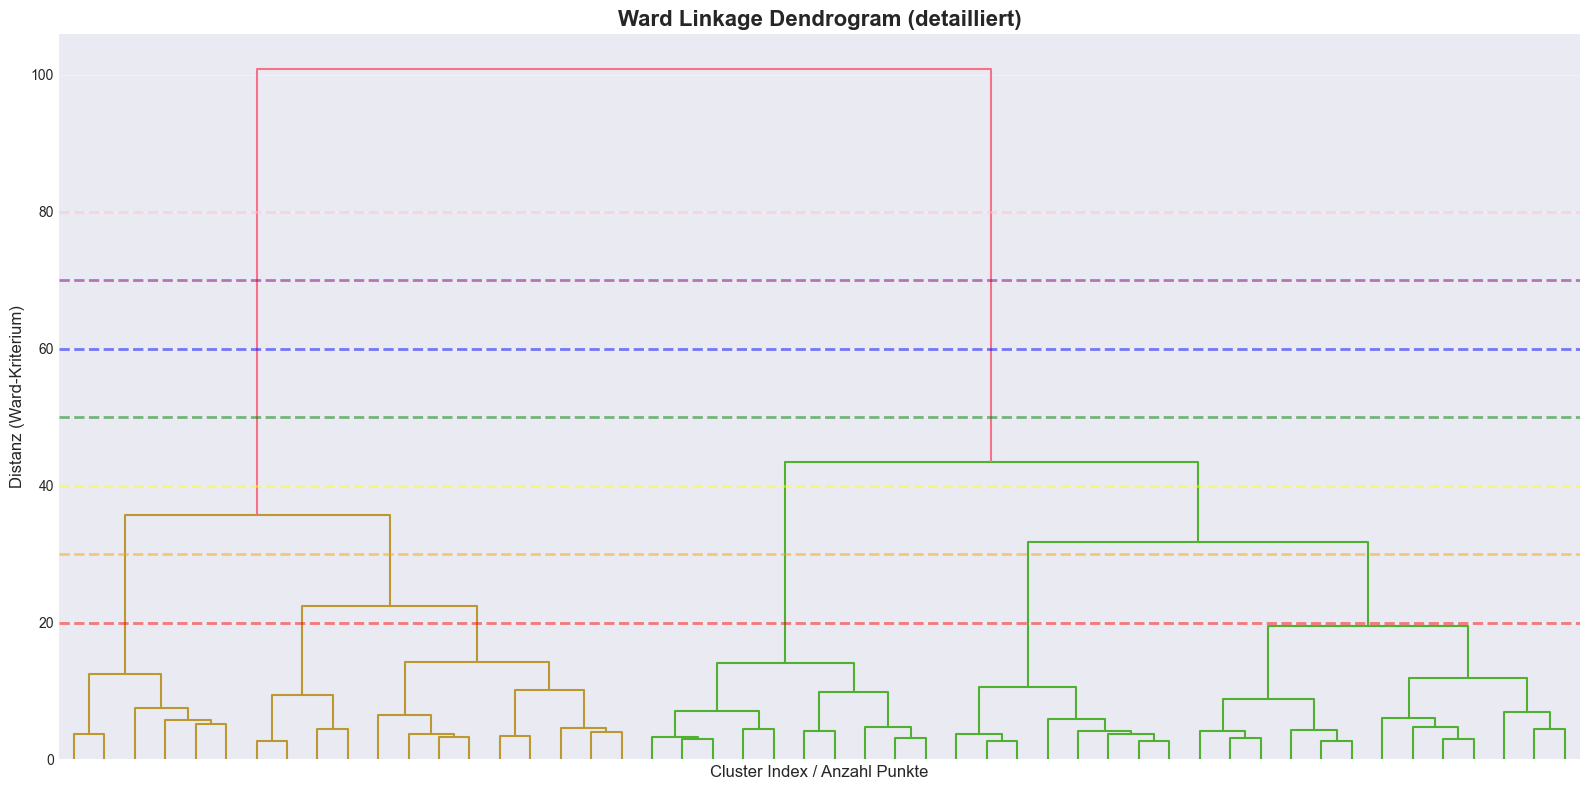


 Interpretation:
Je höher wir schneiden, desto weniger Cluster
Große vertikale 'Sprünge' = gute Trennpunkte

Schaue wo die größten Abstände zwischen horizontalen Verschmelzungen sind!


In [41]:
# Detailliertes Ward-Dendrogram mit mehr Informationen
plt.figure(figsize=(16, 8))

# Vollständiges Dendrogram (nicht truncated)
dendrogram_data = dendrogram(
    linkages['ward'],
    truncate_mode='lastp',
    p=50,  # Zeige letzte 50 Cluster
    no_labels=True,
    leaf_font_size=10,
    color_threshold=None
)

plt.title('Ward Linkage Dendrogram (detailliert)', fontsize=16, fontweight='bold')
plt.xlabel('Cluster Index / Anzahl Punkte', fontsize=12)
plt.ylabel('Distanz (Ward-Kriterium)', fontsize=12)

# Horizontale Linien für mögliche Schnitte zeichnen
possible_cuts = [20, 30, 40, 50, 60, 70, 80]
colors_lines = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink']

for cut, color in zip(possible_cuts, colors_lines):
    plt.axhline(y=cut, color=color, linestyle='--', alpha=0.5, linewidth=2)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Interpretation:")
print("Je höher wir schneiden, desto weniger Cluster")
print("Große vertikale 'Sprünge' = gute Trennpunkte")
print("\nSchaue wo die größten Abstände zwischen horizontalen Verschmelzungen sind!")

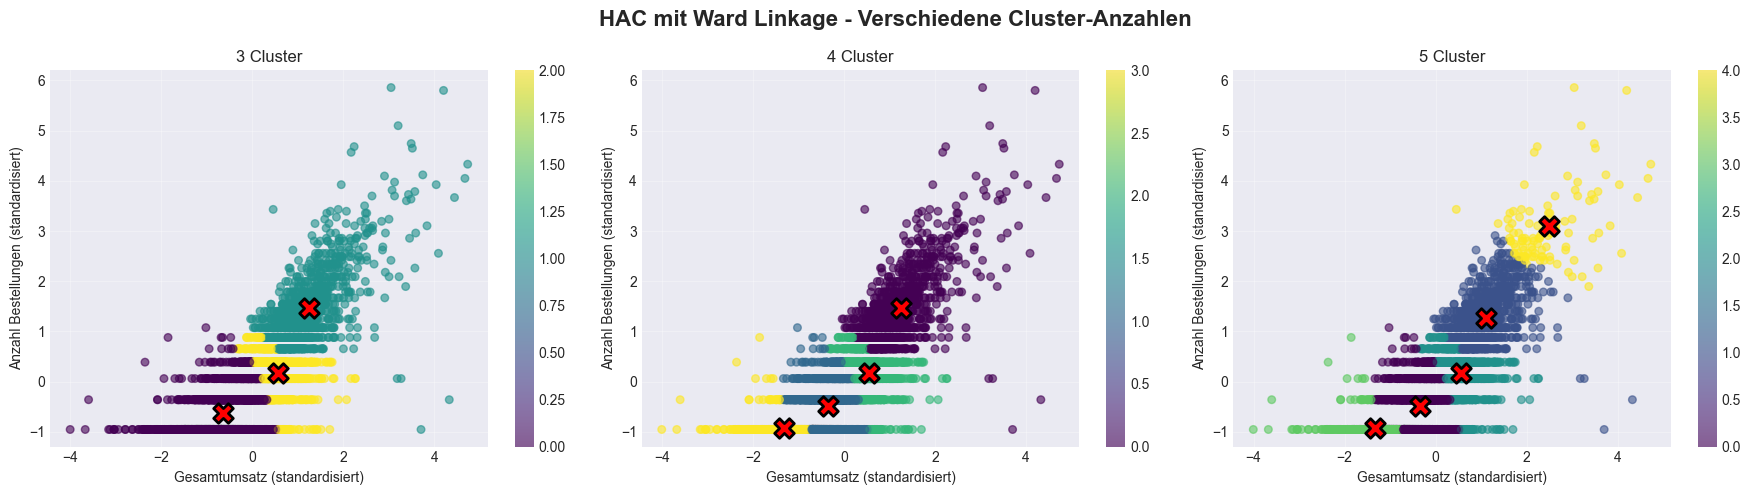


 Vergleich der Cluster-Anzahlen abgeschlossen!
Welche Anzahl sieht am sinnvollsten aus?


In [44]:
# Verschiedene Cluster-Anzahlen testen (3, 4, 5)
test_n_clusters = [3, 4, 5]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('HAC mit Ward Linkage - Verschiedene Cluster-Anzahlen', 
             fontsize=16, fontweight='bold')

for idx, n_clusters in enumerate(test_n_clusters):
    # HAC durchführen
    hac = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = hac.fit_predict(X_scaled)
    
    # Scatter Plot
    scatter = axes[idx].scatter(X_scaled_df['Gesamtumsatz_scaled'], 
                                X_scaled_df['Anzahl_Bestellungen_scaled'],
                                c=labels, cmap='viridis', alpha=0.6, s=30)
    
    axes[idx].set_xlabel('Gesamtumsatz (standardisiert)')
    axes[idx].set_ylabel('Anzahl Bestellungen (standardisiert)')
    axes[idx].set_title(f'{n_clusters} Cluster')
    axes[idx].grid(True, alpha=0.3)
    
    # Cluster-Zentren berechnen und einzeichnen
    for cluster_id in range(n_clusters):
        cluster_mask = labels == cluster_id
        center_x = X_scaled_df.loc[cluster_mask, 'Gesamtumsatz_scaled'].mean()
        center_y = X_scaled_df.loc[cluster_mask, 'Anzahl_Bestellungen_scaled'].mean()
        axes[idx].scatter(center_x, center_y, c='red', marker='X', s=200, 
                         edgecolors='black', linewidth=2)
    
    plt.colorbar(scatter, ax=axes[idx])

plt.tight_layout()
plt.savefig('../results/figures/03_Empfehlende_Cluster.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Vergleich der Cluster-Anzahlen abgeschlossen!")
print("Welche Anzahl sieht am sinnvollsten aus?")

In [46]:
# Finale HAC mit 4 Clustern (Ward Linkage)
n_clusters_final = 4

hac_final = AgglomerativeClustering(n_clusters=n_clusters_final, linkage='ward')
customer_features['Cluster'] = hac_final.fit_predict(X_scaled)

print(f" HAC mit {n_clusters_final} Clustern durchgeführt!")
print(f"\nCluster-Verteilung:")
print(customer_features['Cluster'].value_counts().sort_index())

 HAC mit 4 Clustern durchgeführt!

Cluster-Verteilung:
Cluster
0     987
1    1768
2     781
3     802
Name: count, dtype: int64


In [47]:
# Durchschnittliche Werte pro Cluster berechnen
cluster_profile = customer_features.groupby('Cluster').agg({
    'Gesamtumsatz': ['mean', 'median', 'std'],
    'Anzahl_Bestellungen': ['mean', 'median', 'std'],
    'Anzahl_Produkte': ['mean', 'median'],
    'Recency_Tage': ['mean', 'median'],
    'Avg_Warenkorbwert': ['mean', 'median'],
    'CustomerID': 'count'  # Anzahl Kunden
}).round(2)

cluster_profile.columns = ['_'.join(col).strip() for col in cluster_profile.columns.values]
cluster_profile = cluster_profile.rename(columns={'CustomerID_count': 'Anzahl_Kunden'})

print("=" * 80)
print("CLUSTER PROFILE - Durchschnittswerte pro Segment")
print("=" * 80)
print(cluster_profile)

CLUSTER PROFILE - Durchschnittswerte pro Segment
         Gesamtumsatz_mean  Gesamtumsatz_median  Gesamtumsatz_std  \
Cluster                                                             
0                  6637.70              2975.59          18052.69   
1                   519.25               470.56            226.81   
2                  1688.52              1344.78           1200.29   
3                   153.64               153.91             61.41   

         Anzahl_Bestellungen_mean  Anzahl_Bestellungen_median  \
Cluster                                                         
0                           11.78                         8.0   
1                            1.89                         2.0   
2                            3.49                         4.0   
3                            1.05                         1.0   

         Anzahl_Bestellungen_std  Anzahl_Produkte_mean  \
Cluster                                                  
0                          13

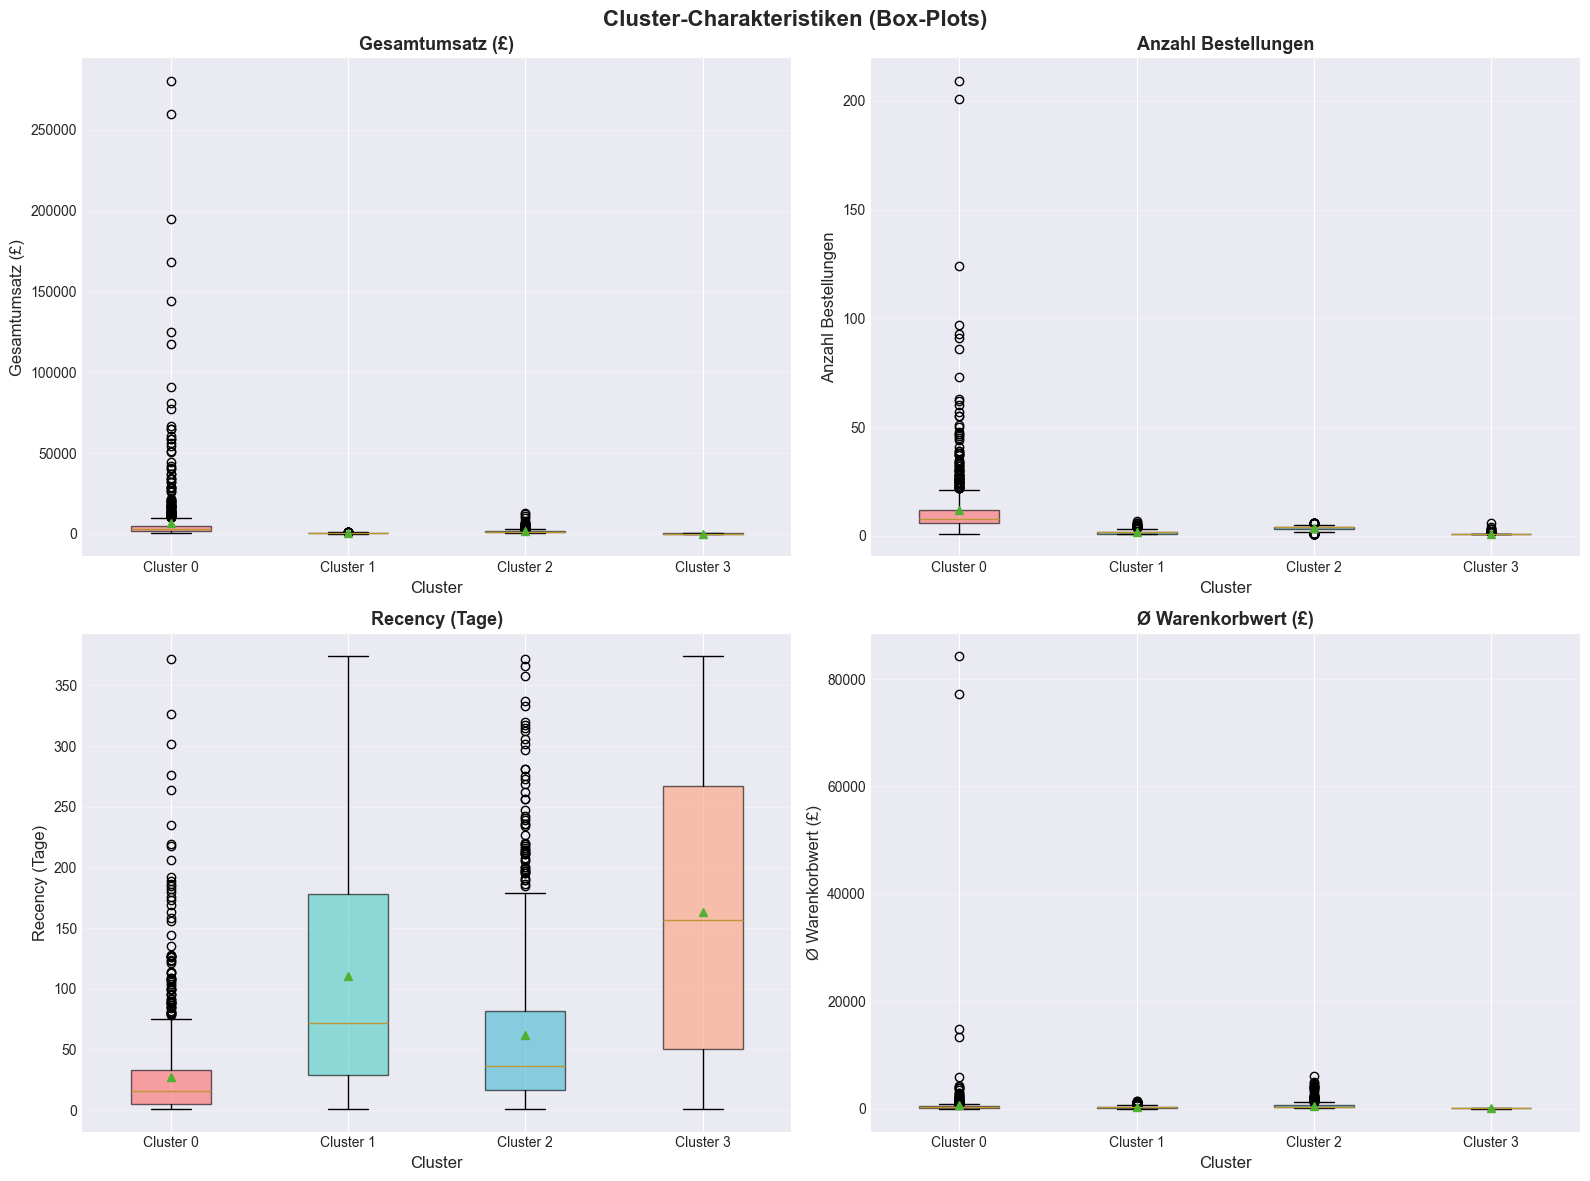

In [48]:
# Box-Plots für jedes Cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cluster-Charakteristiken (Box-Plots)', fontsize=16, fontweight='bold')

features_to_plot = ['Gesamtumsatz', 'Anzahl_Bestellungen', 'Recency_Tage', 'Avg_Warenkorbwert']
titles = ['Gesamtumsatz (£)', 'Anzahl Bestellungen', 'Recency (Tage)', 'Ø Warenkorbwert (£)']

for idx, (feature, title) in enumerate(zip(features_to_plot, titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Box-Plot für jedes Cluster
    data_to_plot = [customer_features[customer_features['Cluster'] == i][feature] 
                    for i in range(n_clusters_final)]
    
    bp = ax.boxplot(data_to_plot, labels=[f'Cluster {i}' for i in range(n_clusters_final)],
                    patch_artist=True, showmeans=True)
    
    # Farben
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax.set_ylabel(title, fontsize=12)
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

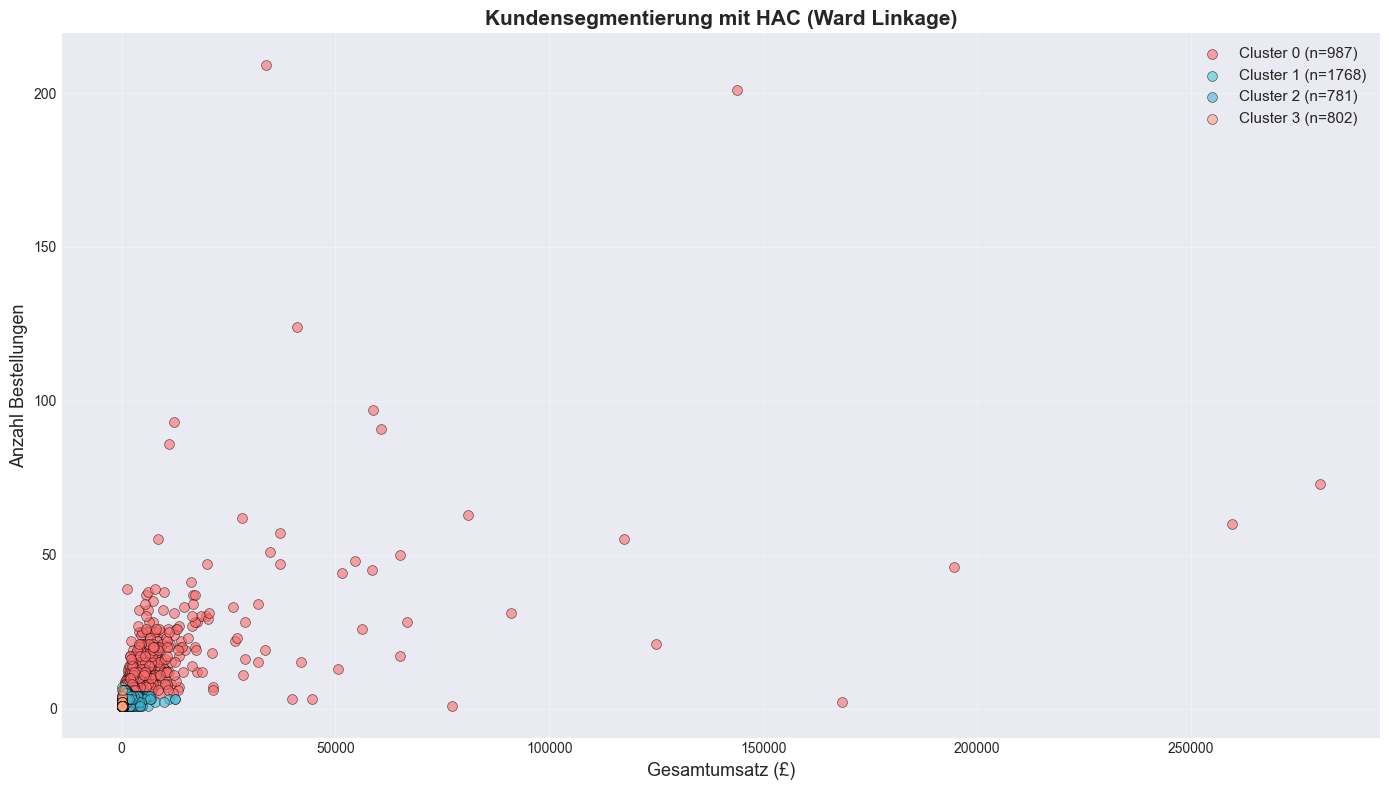


 Jetzt interpretieren wir die Cluster basierend auf den Statistiken!


In [49]:
# Finale Visualisierung mit Cluster-Namen
plt.figure(figsize=(14, 8))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
cluster_names = ['TBD 0', 'TBD 1', 'TBD 2', 'TBD 3']  # Werden gleich benannt

for cluster_id in range(n_clusters_final):
    cluster_mask = customer_features['Cluster'] == cluster_id
    plt.scatter(customer_features.loc[cluster_mask, 'Gesamtumsatz'],
                customer_features.loc[cluster_mask, 'Anzahl_Bestellungen'],
                label=f'Cluster {cluster_id} (n={cluster_mask.sum()})',
                alpha=0.6, s=50, color=colors[cluster_id], edgecolors='black', linewidth=0.5)

plt.xlabel('Gesamtumsatz (£)', fontsize=13)
plt.ylabel('Anzahl Bestellungen', fontsize=13)
plt.title('Kundensegmentierung mit HAC (Ward Linkage)', fontsize=15, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Jetzt interpretieren wir die Cluster basierend auf den Statistiken!")

In [51]:
# Cluster-Namen und Interpretation
cluster_interpretation = {
    0: {
        'Name': 'VIP-Kunden (Champions)',
        'Beschreibung': 'Höchster Umsatz, viele Bestellungen, kürzlich aktiv',
        'Größe': 987,
        'Prozent': f"{987/4338*100:.1f}%",
        'Marketing': 'Exklusive Angebote, VIP-Programm, persönlicher Service',
        'Farbe': '#FF6B6B'
    },
    1: {
        'Name': 'Inaktive Gelegenheitskäufer',
        'Beschreibung': 'Wenige Bestellungen, mittlerer Umsatz, lange inaktiv',
        'Größe': 1768,
        'Prozent': f"{1768/4338*100:.1f}%",
        'Marketing': 'Re-Engagement Kampagnen, Sonderrabatte, Erinnerungen',
        'Farbe': '#4ECDC4'
    },
    2: {
        'Name': 'Loyale Stammkunden',
        'Beschreibung': 'Regelmäßige Käufer, guter Warenkorbwert, moderat aktiv',
        'Größe': 781,
        'Prozent': f"{781/4338*100:.1f}%",
        'Marketing': 'Treueprogramm, Cross-Selling, neue Produkte',
        'Farbe': '#45B7D1'
    },
    3: {
        'Name': 'Einmalkäufer / At-Risk',
        'Beschreibung': 'Sehr niedriger Umsatz, 1 Bestellung, sehr lange inaktiv',
        'Größe': 802,
        'Prozent': f"{802/4338*100:.1f}%",
        'Marketing': 'Win-back Kampagnen, hohe Rabatte, Umfragen',
        'Farbe': '#FFA07A'
    }
}

# Schöne Übersicht ausgeben
print("=" * 100)
print("KUNDENSEGMENTIERUNG - FINALE CLUSTER-INTERPRETATION")
print("=" * 100)

for cluster_id, info in cluster_interpretation.items():
    print(f"\n CLUSTER {cluster_id}: {info['Name']}")
    print(f"   Größe: {info['Größe']} Kunden ({info['Prozent']})")
    print(f"   Beschreibung: {info['Beschreibung']}")
    print(f"   Marketing-Strategie: {info['Marketing']}")
    print("-" * 100)

# Cluster-Namen in DataFrame hinzufügen
customer_features['Cluster_Name'] = customer_features['Cluster'].map(
    {0: 'VIP-Kunden', 1: 'Inaktive Gelegenheitskäufer', 
     2: 'Loyale Stammkunden', 3: 'Einmalkäufer'}
)

print("\n Cluster-Namen hinzugefügt!")
print(customer_features[['CustomerID', 'Gesamtumsatz', 'Anzahl_Bestellungen', 
                         'Recency_Tage', 'Cluster', 'Cluster_Name']].head(10))

KUNDENSEGMENTIERUNG - FINALE CLUSTER-INTERPRETATION

 CLUSTER 0: VIP-Kunden (Champions)
   Größe: 987 Kunden (22.8%)
   Beschreibung: Höchster Umsatz, viele Bestellungen, kürzlich aktiv
   Marketing-Strategie: Exklusive Angebote, VIP-Programm, persönlicher Service
----------------------------------------------------------------------------------------------------

 CLUSTER 1: Inaktive Gelegenheitskäufer
   Größe: 1768 Kunden (40.8%)
   Beschreibung: Wenige Bestellungen, mittlerer Umsatz, lange inaktiv
   Marketing-Strategie: Re-Engagement Kampagnen, Sonderrabatte, Erinnerungen
----------------------------------------------------------------------------------------------------

 CLUSTER 2: Loyale Stammkunden
   Größe: 781 Kunden (18.0%)
   Beschreibung: Regelmäßige Käufer, guter Warenkorbwert, moderat aktiv
   Marketing-Strategie: Treueprogramm, Cross-Selling, neue Produkte
----------------------------------------------------------------------------------------------------

 CLUSTER 3: 

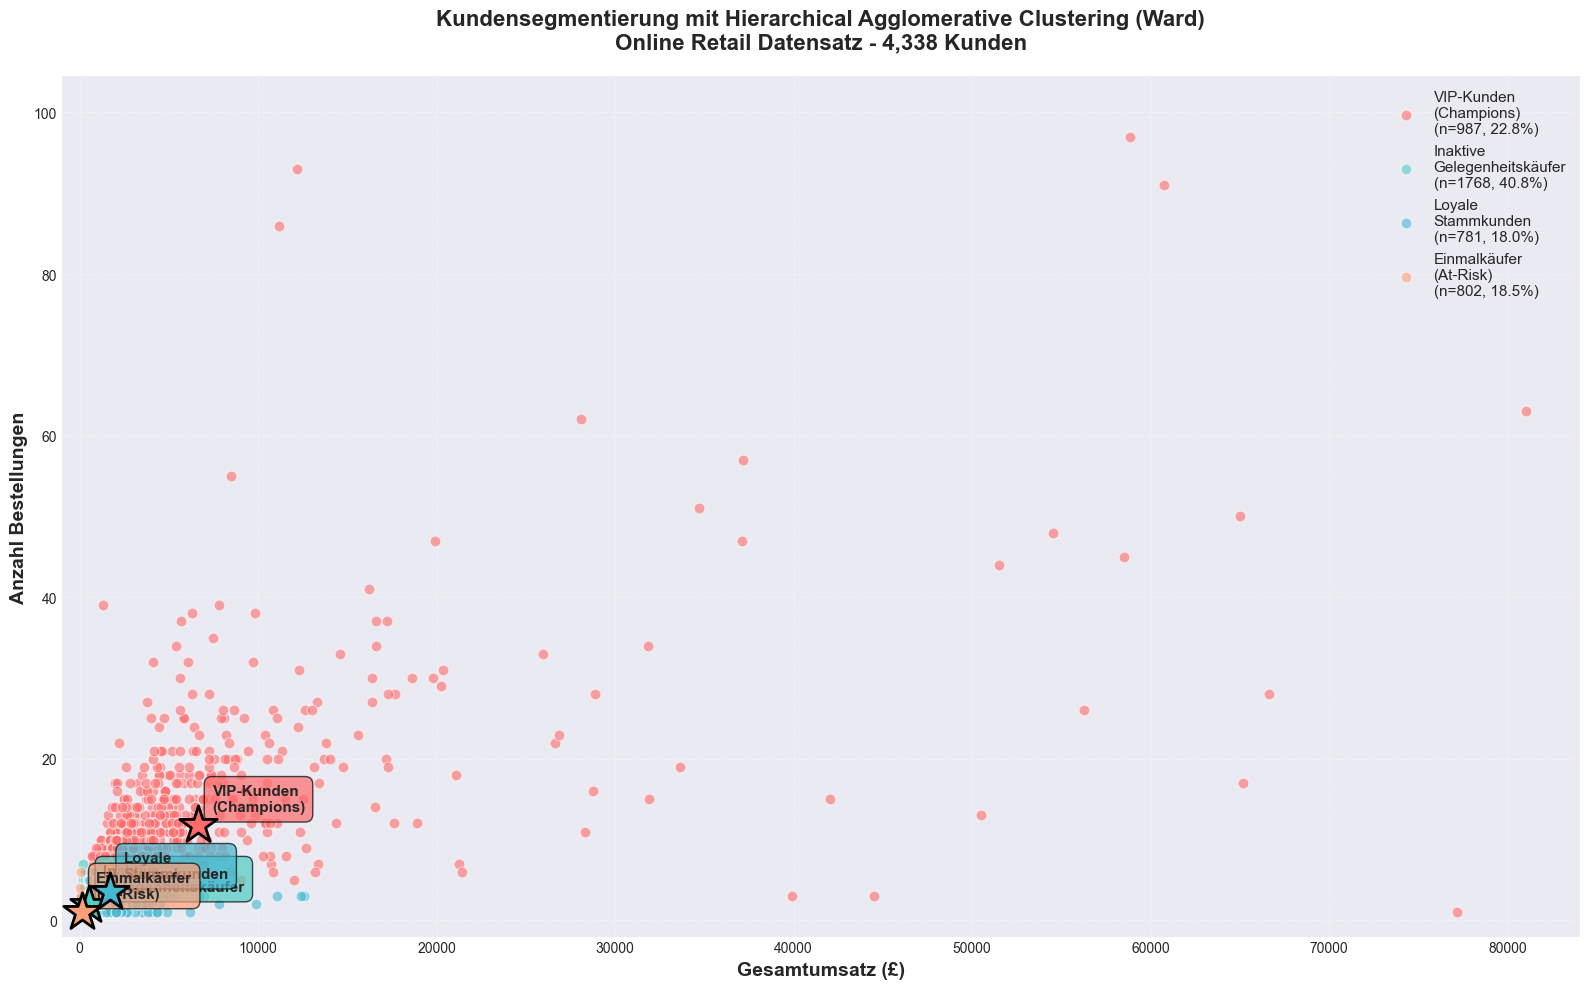

Plot gespeichert unter: results/figures/hac_clustering_final.png


In [52]:
# Finale professionelle Visualisierung
fig, ax = plt.subplots(figsize=(16, 10))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
cluster_names = ['VIP-Kunden\n(Champions)', 
                 'Inaktive\nGelegenheitskäufer',
                 'Loyale\nStammkunden', 
                 'Einmalkäufer\n(At-Risk)']

for cluster_id in range(n_clusters_final):
    cluster_mask = customer_features['Cluster'] == cluster_id
    cluster_data = customer_features[cluster_mask]
    
    ax.scatter(cluster_data['Gesamtumsatz'],
               cluster_data['Anzahl_Bestellungen'],
               label=f'{cluster_names[cluster_id]}\n(n={cluster_mask.sum()}, {cluster_mask.sum()/len(customer_features)*100:.1f}%)',
               alpha=0.6, s=60, color=colors[cluster_id], 
               edgecolors='white', linewidth=0.8)
    
    # Cluster-Zentrum markieren
    center_x = cluster_data['Gesamtumsatz'].mean()
    center_y = cluster_data['Anzahl_Bestellungen'].mean()
    ax.scatter(center_x, center_y, c=colors[cluster_id], marker='*', 
               s=800, edgecolors='black', linewidth=2, zorder=5)
    
    # Cluster-Name am Zentrum
    ax.annotate(cluster_names[cluster_id], 
                xy=(center_x, center_y),
                xytext=(10, 10), textcoords='offset points',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[cluster_id], alpha=0.7),
                ha='left')

ax.set_xlabel('Gesamtumsatz (£)', fontsize=14, fontweight='bold')
ax.set_ylabel('Anzahl Bestellungen', fontsize=14, fontweight='bold')
ax.set_title('Kundensegmentierung mit Hierarchical Agglomerative Clustering (Ward)\n' + 
             'Online Retail Datensatz - 4,338 Kunden',
             fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

# Achsen-Limits für bessere Lesbarkeit
ax.set_xlim(-1000, max(customer_features['Gesamtumsatz']) * 0.3)  # Zoom auf Hauptbereich
ax.set_ylim(-2, max(customer_features['Anzahl_Bestellungen']) * 0.5)

plt.tight_layout()
plt.savefig('../results/figures/hac_clustering_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot gespeichert unter: results/figures/hac_clustering_final.png")

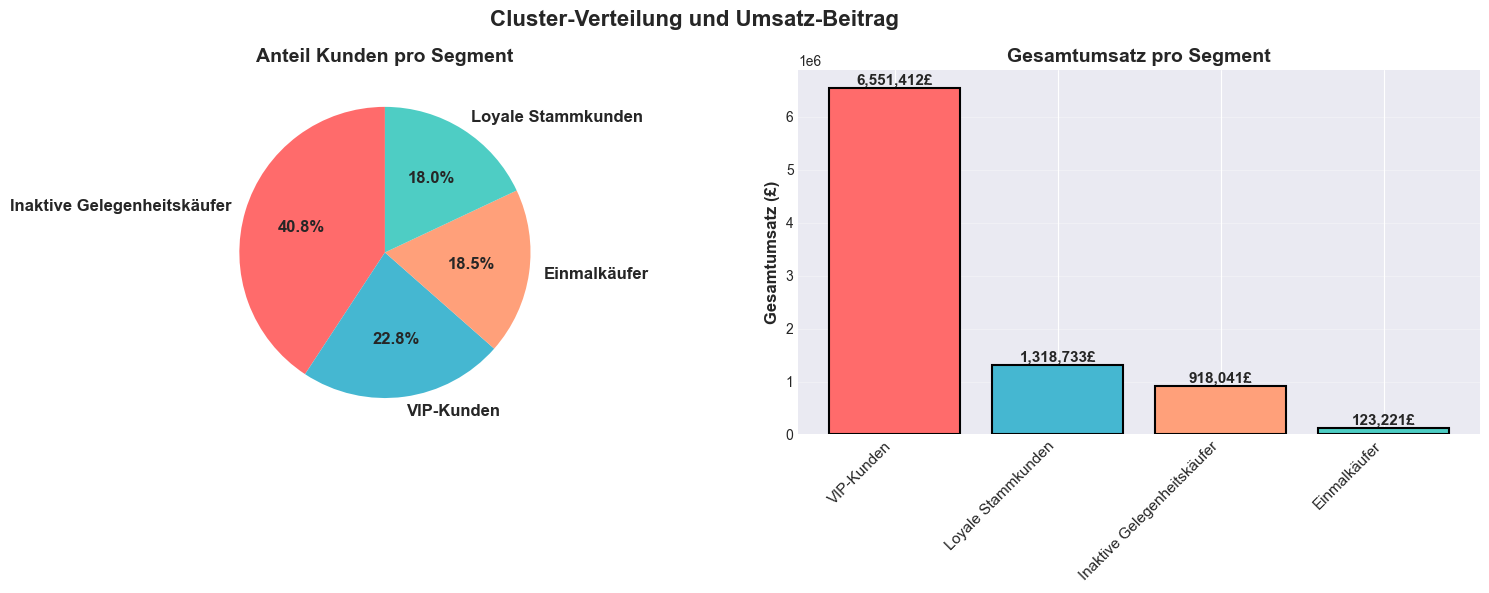

Plot gespeichert unter: results/figures/hac_cluster_distribution.png


In [53]:
# Cluster-Verteilung visualisieren
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Cluster-Verteilung und Umsatz-Beitrag', fontsize=16, fontweight='bold')

# Pie Chart: Anzahl Kunden
cluster_counts = customer_features['Cluster_Name'].value_counts()
colors_pie = ['#FF6B6B', '#45B7D1', '#FFA07A', '#4ECDC4']

axes[0].pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%',
            colors=colors_pie, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0].set_title('Anteil Kunden pro Segment', fontsize=14, fontweight='bold')

# Bar Chart: Gesamtumsatz pro Cluster
cluster_revenue = customer_features.groupby('Cluster_Name')['Gesamtumsatz'].sum().sort_values(ascending=False)

bars = axes[1].bar(range(len(cluster_revenue)), cluster_revenue.values, 
                   color=colors_pie, edgecolor='black', linewidth=1.5)

axes[1].set_xticks(range(len(cluster_revenue)))
axes[1].set_xticklabels(cluster_revenue.index, rotation=45, ha='right', fontsize=11)
axes[1].set_ylabel('Gesamtumsatz (£)', fontsize=12, fontweight='bold')
axes[1].set_title('Gesamtumsatz pro Segment', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Werte auf Balken anzeigen
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}£',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/hac_cluster_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot gespeichert unter: results/figures/hac_cluster_distribution.png")